# Prediksi Jumlah Pengunjung Coffee Shop

### Latar Belakang
Coffee shop telah menjadi bagian penting dalam gaya hidup masyarakat modern, Tidak hanya menjadi tempat untuk menikmati kopi, coffee shop juga berfungsi sebagai tempat bersosialisasi, bekerja, belajar, dan bahkan menghadiri berbagai acara. Dengan semakin banyaknya coffee shop yang bermunculan, persaingan antar bisnis semakin ketat. Maka diperlukan kemampuan untuk memprediksi jumlah pengunjung. Data yang digunakan dalam pengerjaan tugas ini berupa data time series penjualan coffe sales yang didapat dari website kaggle [Coffe Sales](https://www.kaggle.com/datasets/ihelon/coffee-sales/data). Dengan memprediksi jumlah pengunjung yang membeli di coffe sales 3 hari kedepan.

### Tujuan
- Untuk mengoptimalkan perencanaan operasional
- Untuk meningkatkan efisiensi biaya produksi dan tenaga kerja

### Rumusan masalah
Bagaimana prediksi jumlah pengunjung dalam kurun waktu 3 hari kedepan?

In [100]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
import xgboost as xgb

## Menampilkan Data

In [101]:
data = 'https://raw.githubusercontent.com/fadh54/Tugas_PSD/refs/heads/main/sales_coffe.csv'
df_baru = pd.read_csv(data, delimiter=';')
df_baru

,date,jumlah_pengunjung
0,01/03/2024,11
1,02/03/2024,7
2,03/03/2024,10
3,04/03/2024,4
4,05/03/2024,9
...,...,...
213,03/10/2024,8
214,04/10/2024,9
215,05/10/2024,6
216,06/10/2024,20


Menampilkan data yang akan digunakan untuk melakukan prediksi

## Data Understanding

In [102]:
# Merubah kolom 'Date' dalam format datetime dengan dayfirst=True
df_baru['date'] = pd.to_datetime(df_baru['date'], dayfirst=True, errors='coerce')

# Mengatur kolom 'Date' sebagai indeks
df_baru.set_index('date', inplace=True)

In [103]:
df_baru.head()

,jumlah_pengunjung
date,
2024-03-01,11
2024-03-02,7
2024-03-03,10
2024-03-04,4
2024-03-05,9


<Axes: xlabel='date'>

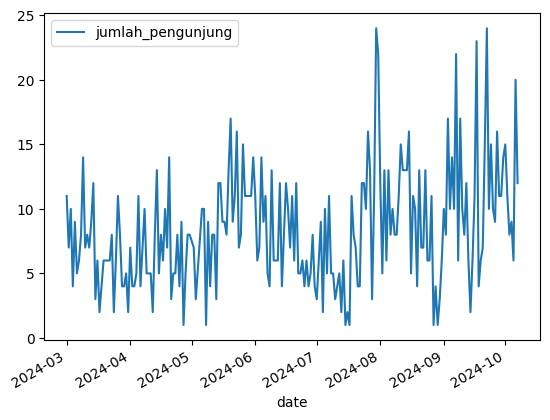

In [104]:
df_baru.plot()

Menampilkan grafik data pengunjung dari tanggal 01/03/2024 sampai dengan tanggal 07/10/2024

In [105]:
df_baru.shape

(218, 1)

In [106]:
df_baru.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 218 entries, 2024-03-01 to 2024-10-07
Data columns (total 1 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   jumlah_pengunjung  218 non-null    int64
dtypes: int64(1)
memory usage: 3.4 KB


In [107]:
df_baru.dtypes

,0
jumlah_pengunjung,int64


In [108]:
df_baru.isnull().sum()

,0
jumlah_pengunjung,0


In [109]:
df_baru.describe()

,jumlah_pengunjung
count,218.000000
mean,8.394495
std,4.458758
min,1.000000
25%,5.000000
50%,8.000000
75%,11.000000
max,24.000000


## Data Prepocessing

### Sliding Window

In [110]:
def sliding_window(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)].flatten())
        y.append(data[i + window_size])
    return pd.DataFrame(X), pd.DataFrame(y)

# Menggunakan fungsi sliding window
window_size = 3
X, y = sliding_window(df_baru['jumlah_pengunjung'].values.reshape(-1, 1), window_size)

# Menampilkan hasil
X.columns = [f'lag_{i}' for i in range(window_size,0,-1)]
y.columns = ['target']
result = pd.concat([X, y], axis=1)

print(result.head())

   lag_3  lag_2  lag_1  target
0     11      7     10       4
1      7     10      4       9
2     10      4      9       5
3      4      9      5       6
4      9      5      6       8


melakukan slidding window untuk mendapatkan data penjualan 3 hari sebelumnya yang akan digunakan untuk melakukan prediksi jumlah pengunjung

## Normalisasi

In [111]:
target = df_baru['jumlah_pengunjung']

# Scale data
scaler = MinMaxScaler()
df_baru['jumlah_pengunjung'] = scaler.fit_transform(df_baru[['jumlah_pengunjung']])

def normalisasi_sliding_window(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size)].flatten())
        y.append(data[i + window_size])
    return pd.DataFrame(X), pd.DataFrame(y)

window_size = 3
X, y = normalisasi_sliding_window(df_baru['jumlah_pengunjung'].values.reshape(-1, 1), window_size)

# Menampilkan hasil
X.columns = [f'lag_{i}' for i in range(window_size,0,-1)]
y.columns = ['target']
result = pd.concat([X, y], axis=1)

print(result.head())

      lag_3     lag_2     lag_1    target
0  0.434783  0.260870  0.391304  0.130435
1  0.260870  0.391304  0.130435  0.347826
2  0.391304  0.130435  0.347826  0.173913
3  0.130435  0.347826  0.173913  0.217391
4  0.347826  0.173913  0.217391  0.304348


data slidding window yang sudah didapatkan akan dinormalisasi

## Transformasi Data


In [112]:
# Membagi data menjadi data train dan test (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Menampilkan jumlah data train dan test
print("Jumlah data train:", len(X_train))
print("Jumlah data test:", len(X_test))

Jumlah data train: 172
Jumlah data test: 43


membagi data menjadi data train dan data test, dengan presentase 80% data train dan 20% data test

## Modeling

### Evaluasi Model

#### 1. MSE (Mean Squared Error)
- *Definisi*: MSE adalah rata-rata dari kuadrat selisih antara nilai yang diprediksi dan nilai aktual.
- *Rumus*:
  $$
  \text{MSE} = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2
  $$
  Di mana $y_i$ adalah nilai aktual, $\hat{y}_i$ adalah nilai prediksi, dan $n$ adalah jumlah data.

#### 2. RMSE (Root Mean Squared Error)
- *Definisi*: RMSE adalah akar kuadrat dari MSE, yang mengembalikan satuan ke skala yang sama dengan data asli.
- *Rumus*:
  $$
  \text{RMSE} = \sqrt{\text{MSE}}
  $$

#### 3. MAPE (Mean Absolute Percentage Error)
- *Definisi*: MAPE mengukur kesalahan dalam prediksi sebagai persentase dari nilai aktual.
- *Rumus*:
  $$
  \text{MAPE} = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right| \times 100\%
  $$

### Begging Regresor

Rumus algoritma decision tree:
- Menghitung Entropy
  
  untuk menghitung ketidakpastian dalam data.
  $$
  \text {H(S)} = - \sum_{i=1}^{k} {p_i} . {log_2(p_i)}
  $$

  ${H(S)}$: Entropi dari dataset $S$
  
  ${p_i}$: Proporsi sampel kelas ke-$i$ dalam dataset $S$.
  
  ${k}$: Jumlah kelas dalam dataset.

- Menghitung Gain
  $$
  \text {IG}{(S,A)} = {H(S)} - \sum_{v∈V}^{k} \frac{|S_v|}{|S|} . {H}{(S_v)}
  $$
  
  ${H(S)}$ : Entropi dataset sebelum split.

  ${S_v}$ : Subset data setelah split berdasarkan nilai ${v}$ dari fitur ${A}$.

  ${|S_v|}$ : Jumlah sampel dalam subset ${|S_v|}$.

  ${|S|}$ : Total sampel dalam dataset ${S}$.

In [113]:
model_begging = BaggingRegressor(estimator=DecisionTreeRegressor(), n_estimators=20, random_state=42)
model_begging.fit(X_train, y_train)
y_pred = model_begging.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:581: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


jumlah pengunjung 1 hari ke depan  [0.4217391304347828, 0.33260869565217405]


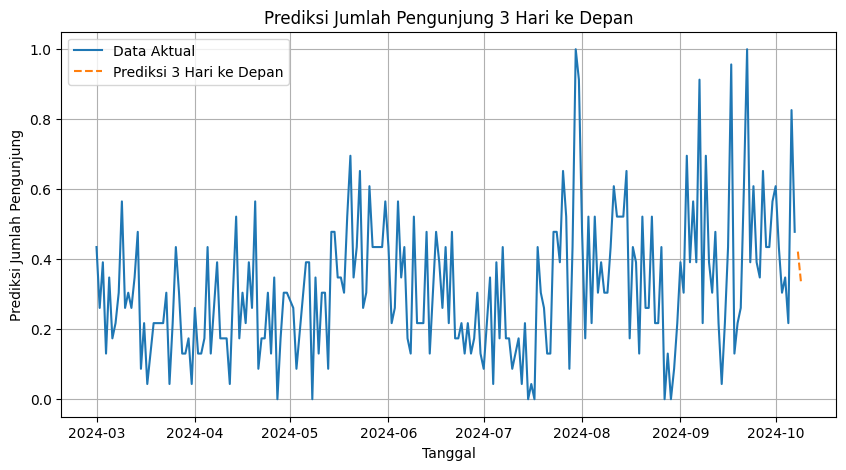

In [114]:
# memprediksi jumlah pengunjung 7 hari ke depan
def predict_future(model_begging, last_window, steps=1):
    future_predictions = []
    for _ in range(steps):
        # Ensure current_window has the same column order as X_train
        current_window = pd.DataFrame([last_window], columns=X_train.columns)
        prediction = model_begging.predict(current_window)
        future_predictions.append(prediction[0])
        # Update current window dengan prediksi terbaru
        last_window = np.roll(last_window, -1)
        last_window[-1] = prediction[0]
    return future_predictions

# # Ambil jendela terakhir dari data
last_window = X.values[-1]

# # Prediksi 7 hari ke depan
future_steps = 2
future_predictions = predict_future(model_begging, last_window, future_steps)

# # Tampilkan prediksi masa depan
# future_df = pd.date_range(start=df_baru['date'].iloc[-1] + pd.DateOffset(days=1), periods=future_steps, freq='D')
future_df = pd.date_range(start=df_baru.index[-1] + pd.DateOffset(days=1), periods=future_steps, freq='D')
print("jumlah pengunjung 1 hari ke depan ",future_predictions)

plt.figure(figsize=(10, 5))
plt.plot(df_baru.index, df_baru['jumlah_pengunjung'], label='Data Aktual')
plt.plot(future_df, future_predictions, label='Prediksi 3 Hari ke Depan', linestyle='--')
plt.title('Prediksi Jumlah Pengunjung 3 Hari ke Depan')
plt.xlabel('Tanggal')
plt.ylabel('Prediksi Jumlah Pengunjung')
plt.grid()
plt.legend()
plt.show()

In [115]:
# Menghitung MSE, MAE, RMSE, R² dan MAPE
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)

print(f"{'Bagging Regressor'} \n MSE: {mse}\n MAE: {mae}\n RMSE: {rmse}\n R²: {r2}\n MAPE: {mape}%")

Bagging Regressor 
 MSE: 0.03836109377060711
 MAE: 0.15534209639366364
 RMSE: 0.19585988300468044
 R²: -0.02039028064831938
 MAPE: 32331200560496.82%


### Linear Regression

Rumus algoritma Regresi Linear

Regresi linear dapat dinyatakan dengan rumus:

$$
y = \beta_0 + \beta_1 x_1 + \beta_2 x_2 + ... + \beta_n x_n + \epsilon
$$

di mana:
- $y$ adalah variabel dependen (target).
- $\beta_0$ adalah intercept (konstanta).
- $\beta_1, \beta_2, \ldots, \beta_n$ adalah koefisien regresi untuk masing-masing variabel independen $x_1, x_2, \ldots, x_n$.
- $\epsilon$ adalah error atau residual.

In [116]:
# Model Linear Regression
model_linear = BaggingRegressor(estimator=LinearRegression(), n_estimators=20, random_state=42)
model_linear.fit(X_train, y_train)
y_pred_linear = model_linear.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:581: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


jumlah pengunjung 1 hari ke depan  [0.4057041903961848, 0.43782460834610026, 0.39629435861884466]


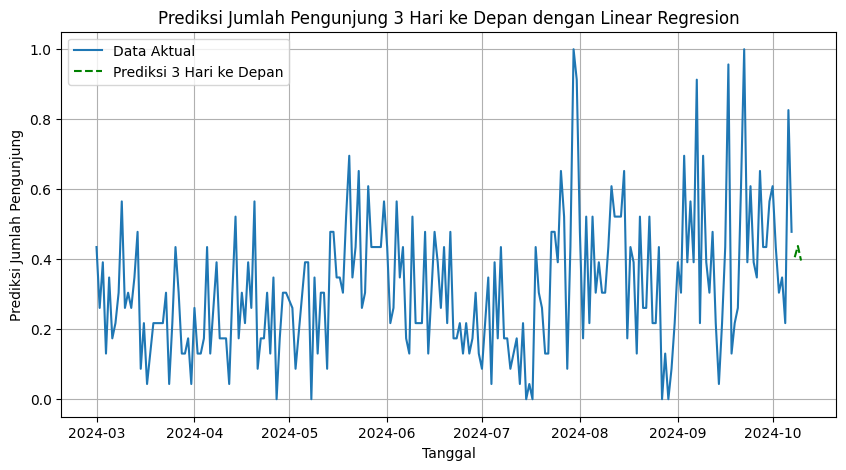

In [117]:
# memprediksi jumlah pengunjung 7 hari ke depan
def predict_future(model, last_window, steps=1):
    future_predictions = []
    for _ in range(steps):
        current_window = pd.DataFrame([last_window], columns=X_train.columns)
        prediction = model.predict(current_window)
        future_predictions.append(prediction[0])
        # Update current window dengan prediksi terbaru
        last_window = np.roll(last_window, -1)
        last_window[-1] = prediction[0]
    return future_predictions

# # Ambil jendela terakhir dari data
last_window = X.values[-1]

# # Prediksi 7 hari ke depan
future_steps = 3
future_predictions = predict_future(model_linear, last_window, future_steps)

# # Tampilkan prediksi masa depan
# future_df = pd.date_range(start=df_baru['date'].iloc[-1] + pd.DateOffset(days=1), periods=future_steps, freq='D')
future_df = pd.date_range(start=df_baru.index[-1] + pd.DateOffset(days=1), periods=future_steps, freq='D')
print("jumlah pengunjung 1 hari ke depan ",future_predictions)

plt.figure(figsize=(10, 5))
plt.plot(df_baru.index, df_baru['jumlah_pengunjung'], label='Data Aktual')
# plt.plot(X_test.index, y_pred, label='Prediksi Linear Regression (Test)', color='green', linestyle='--')
plt.plot(future_df, future_predictions, label='Prediksi 3 Hari ke Depan',color='green', linestyle='--')
plt.title('Prediksi Jumlah Pengunjung 3 Hari ke Depan dengan Linear Regresion')
plt.xlabel('Tanggal')
plt.ylabel('Prediksi Jumlah Pengunjung')
plt.grid()
plt.legend()
plt.show()

In [118]:
# Menghitung MSE, MAE, RMSE, R² dan MAPE
mse = mean_squared_error(y_test, y_pred_linear)
mae = mean_absolute_error(y_test, y_pred_linear)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_linear)
mape = mean_absolute_percentage_error(y_test, y_pred_linear)
print(f"{'Linear Regression'} \n MSE: {mse}\n MAE: {mae}\n RMSE: {rmse}\n R²: {r2}\n MAPE: {mape}%")

Linear Regression 
 MSE: 0.03203098961882884
 MAE: 0.13880708757109858
 RMSE: 0.17897203585708255
 R²: 0.1479880453345349
 MAPE: 23832338379330.22%


### Support Vector Machine

Rumus Algoritma SVM
  $$
  \hat{y}_i = \sum_{i=1}^{n} ({α}_i - {α}_i^*) K({x}_i, {x})+b
  $$

  $\hat{y}$ : Prediksi nilai target.

  ${n}$ : Jumlah sampel pelatihan.

  ${α}_i, {α}_i^*$ : Parameter Lagrange yang dioptimalkan selama pelatihan.

  $K({x}_i, {x})$ : Kernel yang mengukur kesamaan antara data pelatihan ${(x_i)}$ dan data uji ${x}$ .

In [119]:
model_svm = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=0.1)
model_svm = BaggingRegressor(estimator=model_svm, n_estimators=20, random_state=42)
model_svm.fit(X_train, y_train)
y_pred_svm = model_svm.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_bagging.py:581: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return column_or_1d(y, warn=True)


Prediksi jumlah pengunjung 7 hari ke depan: [0.3535559492434669, 0.360050630844582, 0.41199429058255743, 0.3413282664084044, 0.3445365769319487, 0.3375351319311417, 0.3252669130714079]


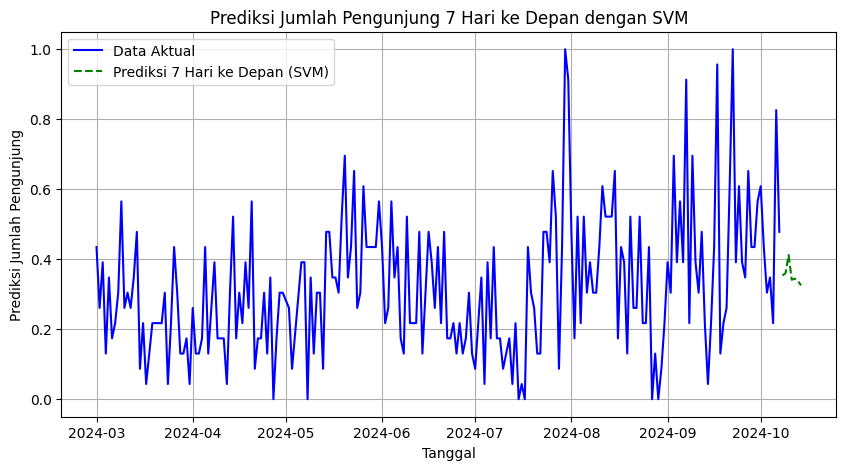

In [120]:
def predict_future(model_svm, last_window, steps=1):
    future_predictions = []
    for _ in range(steps):
        current_window = pd.DataFrame([last_window], columns=X_train.columns)
        prediction = model_svm.predict(current_window)
        future_predictions.append(prediction[0])
        # Update current window dengan prediksi terbaru
        last_window = np.roll(last_window, -1)
        last_window[-1] = prediction[0]
    return future_predictions

# Ambil jendela terakhir dari data
last_window = X.values[-1]

# Prediksi 7 hari ke depan
future_steps = 7
future_predictions = predict_future(model_svm, last_window, future_steps)

# Membuat tanggal untuk prediksi masa depan
future_df = pd.date_range(start=df_baru.index[-1] + pd.DateOffset(days=1), periods=future_steps, freq='D')

# Menampilkan prediksi jumlah pengunjung
print("Prediksi jumlah pengunjung 7 hari ke depan:", future_predictions)

# Visualisasi prediksi
plt.figure(figsize=(10, 5))
plt.plot(df_baru.index, df_baru['jumlah_pengunjung'], label='Data Aktual', color='blue')
plt.plot(future_df, future_predictions, label='Prediksi 7 Hari ke Depan (SVM)', color='green', linestyle='--')
plt.title('Prediksi Jumlah Pengunjung 7 Hari ke Depan dengan SVM')
plt.xlabel('Tanggal')
plt.ylabel('Prediksi Jumlah Pengunjung')
plt.grid()
plt.legend()
plt.show()

In [121]:
# Menghitung MSE, MAE, RMSE, R² dan MAPE
mse = mean_squared_error(y_test, y_pred_svm)
mae = mean_absolute_error(y_test, y_pred_svm)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_svm)
mape = mean_absolute_percentage_error(y_test, y_pred_svm)
print(f"{'Support Vector Machine'} \n MSE: {mse}\n MAE: {mae}\n RMSE: {rmse}\n R²: {r2}\n MAPE: {mape}%")

Support Vector Machine 
 MSE: 0.03266111262453388
 MAE: 0.1340574518786111
 RMSE: 0.18072385737509555
 R²: 0.13122701671321368
 MAPE: 23047114794907.586%


Kesimpulan dari hasil prediksi menggunakan ke-3 model tersebut, didapatkan best model nya yaitu prediksi menggunakan Linear regression.